# 단열선도
- 간단한 skew T - log p daigram 그리기
- 자료는 http://weather.uwyo.edu/upperair/sounding.html 에서 받을 수 있음 (단열선도 이미지도 받을 수 있음)

# Siphon
- https://unidata.github.io/siphon/latest/index.html
- 원격서버로부터 자료를 내려받는 것을 지원하는 패키지
- 주로 미국 서버에서 지상 관측(AWS, 부이), 상층 관측, 레이더 자료 등을 받을 수 있음
- conda install -c conda-forge siphon 으로 설치

In [2]:
from datetime import datetime

import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import pandas_dataframe_to_unit_arrays, units
import numpy as np
from siphon.simplewebservice.wyoming import WyomingUpperAir

In [3]:
dt = datetime(2002, 9, 28, 6)
station = 'RKSO'

# 'RKSO': 오산
# 'RKSP': 백령도
# 'RKTH': 포항
# 'RKTD': 대전
# 'RKJJ': 광주
# 'RKPC': 제주
# 'RKNN': 강릉

In [4]:
# Read remote sounding data based on time (dt) and station
df = WyomingUpperAir.request_data(dt, station)

# Create dictionary of united arrays
data = pandas_dataframe_to_unit_arrays(df)

In [5]:
# Isolate united arrays from dictionary to individual variables
p = data['pressure']
T = data['temperature']
Td = data['dewpoint']
u = data['u_wind']
v = data['v_wind']

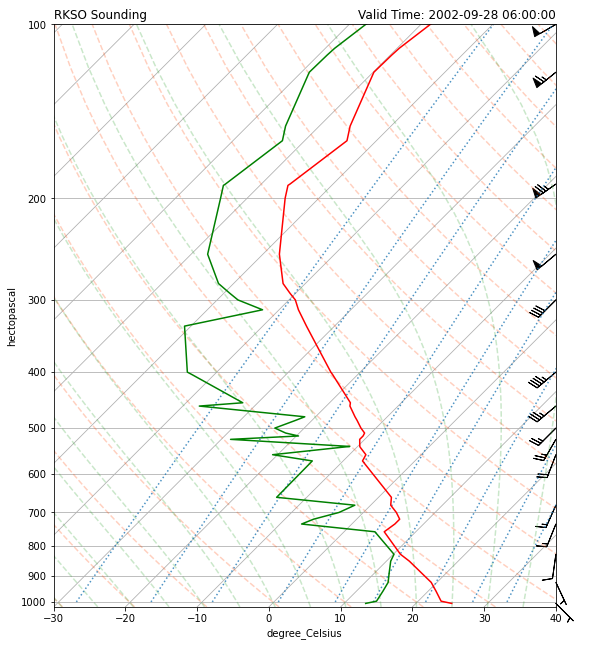

In [6]:
# Change default to be better for skew-T
fig = plt.figure(figsize=(9, 11))

# Initiate the skew-T plot type from MetPy class loaded earlier
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p[::3], u[::3], v[::3], y_clip_radius=0.03)

# Set some appropriate axes limits for x and y
skew.ax.set_xlim(-30, 40)
skew.ax.set_ylim(1020, 100)

# Add the relevant special lines to plot throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(p=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')

# Add some descriptive titles
plt.title('{} Sounding'.format(station), loc='left')
plt.title('Valid Time: {}'.format(dt), loc='right');

In [7]:
import cdsapi

c = cdsapi.Client()
path = 'C:\\Users\\DongGyu_Hyeon\\'
fname1 = 'era5_sfc_' + dt.strftime("%Y%m%d%H") + '.nc'

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            '2m_temperature', 'mean_sea_level_pressure',
        ],
        'year': dt.year,
        'month': dt.month,
        'day': dt.day,
        'time': dt.hour,
        'grid': [1.0, 1.0],
        
    },
    path + fname1)
#

2020-10-30 10:59:26,423 INFO Welcome to the CDS
2020-10-30 10:59:26,438 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2020-10-30 10:59:27,750 INFO Request is completed
2020-10-30 10:59:27,750 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data0/adaptor.mars.internal-1604022662.1039038-24101-27-7f1ff48c-6d71-4a59-9894-c7b001912870.nc to C:\Users\DongGyu_Hyeon\era5_sfc_2002092806.nc (258K)
2020-10-30 10:59:31,806 INFO Download rate 63.6K/s                                                                     


Result(content_length=264176,content_type=application/x-netcdf,location=http://136.156.132.210/cache-compute-0005/cache/data0/adaptor.mars.internal-1604022662.1039038-24101-27-7f1ff48c-6d71-4a59-9894-c7b001912870.nc)

In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr
import os

In [9]:
#-*- encoding: utf8 -*-
path = 'C:\\Users\\DongGyu_Hyeon\\'
fname1 = 'era5_sfc_' + dt.strftime("%Y%m%d%H") + '.nc'
ds = xr.open_dataset(path+fname1)

# Select and grab data, at/lon values 
pres = ds['msl'].sel(time='2002-09-28',latitude=slice(90,0), longitude=slice(60,201))[0,...]
lats = pres.latitude.data
lons = pres.longitude.data

# Select and grab surface pressure, smooth with gaussian_filter
pres = gaussian_filter(pres.data, sigma=3.0) / 100. * units('hPa')
#pres =pres.data / 100. * units('hPa')

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

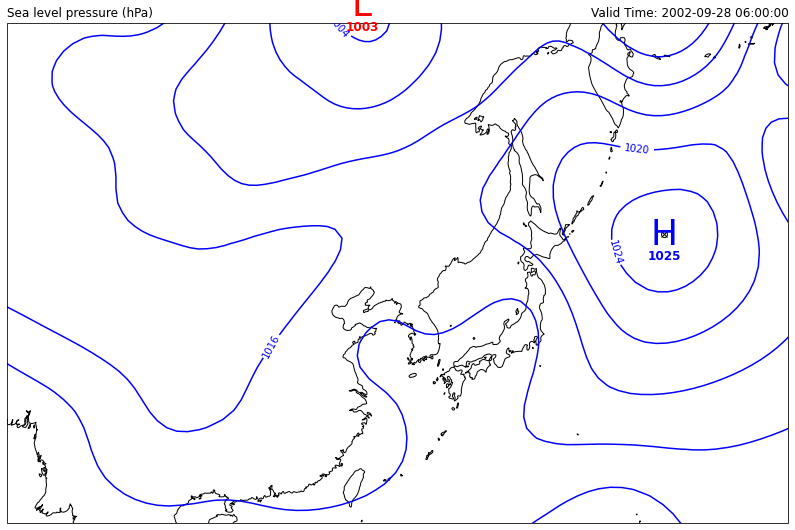

In [12]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.EquidistantConic(central_longitude=125,
                               central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([90, 160, 20, 60], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot surface pressure in hPa
clevs_pres = np.arange(860, 1100, 4)
cs = ax.contour(lons, lats, pres.to('hPa'), clevs_pres, colors='blue', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Use definition to plot H/L symbols
plot_maxmin_points(lons, lats, pres.m, 'max', 50,
                   symbol='H', color='blue', transform=ccrs.PlateCarree())
plot_maxmin_points(lons, lats, pres.m, 'min', 25,
                   symbol='L', color='red', transform=ccrs.PlateCarree())

# Make some nice titles for the plot (one right, one left)
plt.title('Sea level pressure (hPa)',
           loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)

In [13]:
import cdsapi

c = cdsapi.Client()

fname2 = 'era5_pres_' + dt.strftime("%Y%m%d%H") + '.nc'
c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': 
        ['temperature', 'geopotential', 'u_component_of_wind', 'v_component_of_wind'],
        'pressure_level': 
        ['200', '300', '500','700', '850', '925','1000'],
        'year': dt.year,
        'month': dt.month,
        'day': dt.day,
        'time': dt.hour,
        'grid': [1.0, 1.0],
    },
    path + fname2)

2020-10-30 10:59:47,487 INFO Welcome to the CDS
2020-10-30 10:59:47,487 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-10-30 10:59:48,635 INFO Request is completed
2020-10-30 10:59:48,635 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data2/adaptor.mars.internal-1604022285.6583962-16300-27-9a801c5b-da03-403f-8097-2ef3e3de2be4.nc to C:\Users\DongGyu_Hyeon\era5_sfc_2002092806.ncera5_pres_2002092806.nc (3.5M)
2020-10-30 11:00:04,861 INFO Download rate 220.1K/s                                                                    


Result(content_length=3653260,content_type=application/x-netcdf,location=http://136.156.133.36/cache-compute-0010/cache/data2/adaptor.mars.internal-1604022285.6583962-16300-27-9a801c5b-da03-403f-8097-2ef3e3de2be4.nc)

In [14]:
# Select and grab data
ds = xr.open_dataset(path + fname2)
hght = ds['z'].sel(time=dt, level=500, latitude=slice(90,0), longitude=slice(60,201))
uwnd = ds['u'].sel(time=dt, level=500, latitude=slice(90,0), longitude=slice(60,201))
vwnd = ds['v'].sel(time=dt, level=500, latitude=slice(90,0), longitude=slice(60,201))
temp = ds['t'].sel(time=dt, level=500, latitude=slice(90,0), longitude=slice(60,201))
lats = hght.latitude.data
lons = hght.longitude.data

# Select and grab 500-hPa geopotential heights and wind components, smooth with gaussian_filter
g = 9.806
hght_500 = gaussian_filter(hght.data, sigma=3.0) / g *units('m')
uwnd_500 = gaussian_filter(uwnd.data, sigma=3.0) * units('m/s')
vwnd_500 = gaussian_filter(vwnd.data, sigma=3.0) * units('m/s')
temp_500 = gaussian_filter(temp.data, sigma=3.0) * units('K')

# Use MetPy to calculate the wind speed for colorfill plot, change units to knots from m/s
sped_500 = mpcalc.wind_speed(uwnd_500, vwnd_500).to('kt')

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

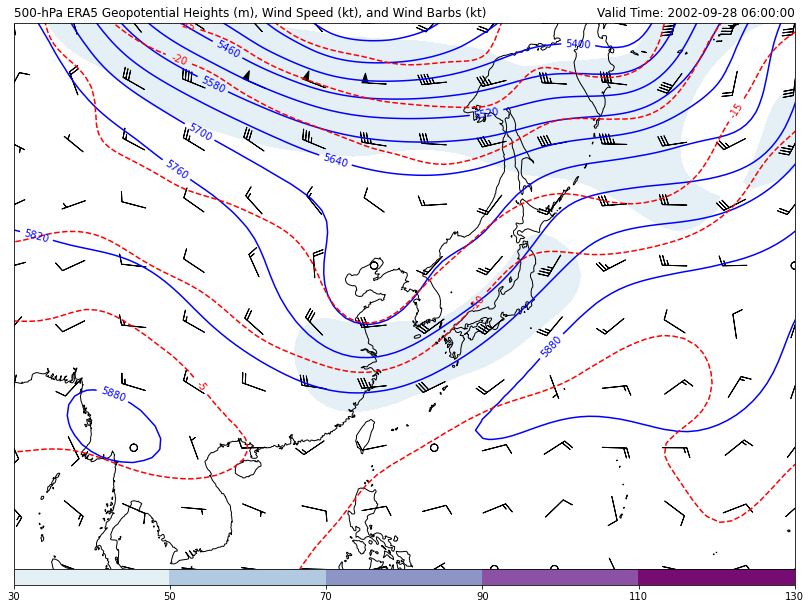

In [15]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.EquidistantConic(central_longitude=125,
                               central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([90, 160, 10, 60], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot 500-hPa Colorfill Wind Speeds in knots
clevs_500_sped = np.arange(30, 150, 20)
cf = ax.contourf(lons, lats, sped_500, clevs_500_sped, cmap=plt.cm.BuPu,
                 transform=datacrs)
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)

# Plot 500-hPa Geopotential Heights in meters
clevs_500_hght = np.arange(0, 8000, 60)
cs = ax.contour(lons, lats, hght_500, clevs_500_hght, colors='blue', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 500-hPa Geopotential Heights in meters
clevs_500_temp = np.arange(-30, 5, 5)
cs = ax.contour(lons, lats, temp_500.to('degC'), clevs_500_temp, colors='red', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 500-hPa wind barbs in knots, regrid to reduce number of barbs
ax.barbs(lons, lats, uwnd_500.to('kt').m, vwnd_500.to('kt').m, pivot='middle',regrid_shape=10, 
         color='black',  transform=datacrs)

# Make some nice titles for the plot (one right, one left)
plt.title('500-hPa ERA5 Geopotential Heights (m), Wind Speed (kt),'
          ' and Wind Barbs (kt)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)

In [11]:
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color.

    Parameters
    ----------
        lon : 2D array
            Plotting longitude values
        lat : 2D array
            Plotting latitude values
        data : 2D array
            Data that you wish to plot the max/min symbol placement
        extrema : str
            Either a value of max for Maximum Values or min for Minimum Values
        nsize : int
            Size of the grid box to filter the max and min values to plot a reasonable number
        symbol : str
            Text to be placed at location of max/min value
        color : str
            Name of matplotlib colorname to plot the symbol (and numerical value, if plotted)
        plot_value : Boolean (True/False)
            Whether to plot the numeric value of max/min point

    Return
    ------
        The max/min symbol will be plotted on the current axes within the bounding frame
        (e.g., clip_on=True)
    """
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    if lon.ndim == 1:
        lon, lat = np.meshgrid(lon, lat)

    mxx, mxy = np.where(data_ext == data)

    for i in range(len(mxy)):
        ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], symbol, color=color, size=36,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                '\n' + str(np.int(data[mxx[i], mxy[i]])),
                color=color, size=12, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)
        ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], marker='o', markeredgecolor='black',
                markerfacecolor='white', transform=transform)
        ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                marker='x', color='black', transform=transform)